In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# load custom libraries
from generate_mission_profile import pnt2line, vector, path_segment

# set output folder
environment_folder = '../environments/5km_world/'

# Developing the Mission Profile
We want a vector field for the uuv to travel in straight lines between waypoints.

The entire path will be generated at once.

A seperate vector field will be calculated for each waypoint.

## Geometry Setup
Global origin is in the bottom left corner (no negative coordinates).

In [2]:
# define the world grid
real_world_size = 5000  # world size in meters
real_world_resolution = 5  # spatial resolution in meters

x_spacing = real_world_resolution
y_spacing = real_world_resolution
max_x = (real_world_size/real_world_resolution) - 1
max_y = (real_world_size/real_world_resolution) - 1

world_x = np.linspace(0,max_x,int(max_x)+1)
world_y = np.linspace(0,max_y,int(max_y)+1)
world_X, world_Y = np.meshgrid(world_x, world_y)

world_z=[0]


In [3]:
# place minefield
mine_min_x = 1000
mine_max_x = 4000
mine_min_y = 1000
mine_max_y = 4000

# use a basic grid
mine_cols = 10
mine_rows = 10
mine_x_arr = np.linspace(mine_min_x, mine_max_x, mine_cols)
mine_y_arr = np.linspace(mine_min_y, mine_max_y, mine_rows)
mine_X, mine_Y = np.meshgrid(mine_x_arr, mine_y_arr)

minefield_df = pd.concat([pd.DataFrame(np.reshape(mine_X,(mine_X.size,1))), pd.DataFrame(np.reshape(mine_Y,(mine_Y.size,1)))], axis=1)


In [4]:
# Define the waypoints of the mission in real world units (meters)
# TODO: generate this programatically
waypoints = [
    (2500,0,0),
    (1000,1000,0),
    (1000,4000,0),
    (1500,4000,0),
    (1500,1000,0),
    (2000,1000,0),
    (2000,4000,0),
    (2500,4000,0),
    (2500,1000,0),
    (3000,1000,0),
    (3000,4000,0),
    (3500,4000,0),
    (3500,1000,0),
    (4000,1000,0),
    (4000,4000,0),
    (2500,0,0),    
]

# normalize waypoints to NetLogo coordinates
waypoints_df = pd.DataFrame(waypoints).apply(lambda x: x/real_world_resolution)

Calculate the vector points based on the closest line point

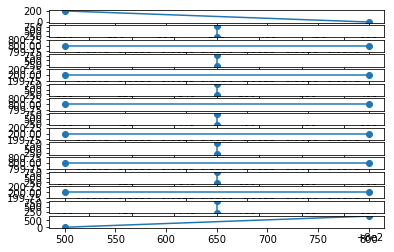

In [5]:
mission_leg = 0  # initialize mission leg counter
mission_array = []

# setup the plot
fig, axs = plt.subplots(len(waypoints)-1, 1)

# loop through each leg
while mission_leg < len(waypoints)-1:
    # define course correction field
    start_point = [ x/real_world_resolution for x in waypoints[mission_leg] ]  # normalize to NetLogo coordinates
    end_point = [ y/real_world_resolution for y in waypoints[mission_leg+1] ]  # normalize to NetLogo coordinates
    x_vec_array, y_vec_array = path_segment(start_point, end_point, world_x, world_y)
    
    # generate mission vector towards goal
    mission_vector = (np.array(end_point) - np.array(start_point))
    segment_length = np.sqrt(mission_vector[0]**2 + mission_vector[1]**2 + mission_vector[2]**2)
    
    mission_x = mission_vector[0]/segment_length
    mission_y = mission_vector[1]/segment_length
    mission_z = mission_vector[2]/segment_length
  
    mission_dx = mission_x * np.ones(world_X.shape)
    mission_dy = mission_y * np.ones(world_Y.shape)
    mission_dz = mission_z * np.ones(world_X.shape)

    # generate behavior vector field
    behavior_dx = mission_dx + x_vec_array
    behavior_dy = mission_dy + y_vec_array
    behavior_dz = np.zeros(behavior_dx.shape)  # no movement in z dimension

    # create pandas dataframe out of the reshaped arrays to feed into NetLogo
    patch_data = pd.concat([pd.DataFrame(np.reshape(world_X,(world_X.size,1))), 
                            pd.DataFrame(np.reshape(world_Y,(world_Y.size,1))),
                            pd.DataFrame(np.reshape(behavior_dx,(behavior_dx.size,1))), 
                            pd.DataFrame(np.reshape(behavior_dy,(behavior_dy.size,1)))], 
                           axis=1)
    # mission_array.append(patch_data)
    patch_data.to_csv(environment_folder + 'mission_leg_' + str(mission_leg) + '.txt', index=False, header=False, sep=' ')
    
    # plot the leg to the ouput figure
    # axs[mission_leg].quiver(world_X, world_Y, behavior_dx, behavior_dy)
    axs[mission_leg].scatter([start_point[0], end_point[0]],[start_point[1],end_point[1]])
    axs[mission_leg].plot([start_point[0], end_point[0]],[start_point[1],end_point[1]])
    
    mission_leg += 1
    
# plt.show()

In [6]:
waypoints_df.to_csv(environment_folder + 'mission_waypoints.txt', index=True, header=False, sep=' ')

In [6]:
minefield_df.to_csv(environment_folder + 'minefield.txt', index=False, header=False, sep=' ')